In [1]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import jax

import optax
from datetime import datetime

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

In [2]:
def fit_sinus(x, y, initial_guess=[1., 0.1, 1]):
    """[A, omega, phi]"""
    x_fit = np.linspace(np.min(x), np.max(x), 500)

    # Define the function to fit (sinusoidal)
    def sinusoidal_func(x, A, omega, phi):
        return A * np.sin(omega * x + phi)

    # Perform the curve fit
    params, _ = curve_fit(sinusoidal_func, np.array(x), np.array(y), maxfev = 10000, p0=initial_guess)

    # Generate the fitted curve
    y_fit = sinusoidal_func(x_fit, *params)
    return x_fit, y_fit, params

In [3]:
wire = 5
dev_sim = qml.device("default.qubit.jax", wires=[wire])
dev_lucy = qml.device("braket.aws.qubit",
    device_arn="arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy",
    wires=range(8), 
    shots=1000,
    parallel=True
)

qubit_freq = dev_lucy.pulse_settings["qubit_freq"][wire]

In [4]:
attenuation = 0.13880127453973318

In [5]:
H_obj = qml.PauliZ(wire)
E_exact = -1
T = 20. # ns

In [8]:
H0 = qml.pulse.transmon_interaction(
    qubit_freq = [qubit_freq],
    connections = [],
    coupling = [],
    wires = [wire]
)

def amp0(p, t):
    return attenuation * p
Hd0 = qml.pulse.transmon_drive(amp0, 0., qubit_freq, wires=[wire])

@jax.jit
@qml.qnode(dev_sim, interface="jax")
def qnode_sim(params, T=T):
    qml.evolve(H0 + Hd0)(params, t=T, atol=1e-15)
    return qml.expval(H_obj)

Hd1 = qml.pulse.transmon_drive(qml.pulse.constant, 0., qubit_freq, wires=[wire])

# setting atol=1 removes the Y and Z components of the effective generator
@qml.qnode(dev_lucy, interface="jax", diff_method=qml.gradients.pulse_generator, atol=1.)
def qnode1_lucy(params, T=T):
    qml.evolve(H0 + Hd1)(params, t=T)
    return qml.expval(H_obj)

def qnode_lucy(params):
    # jax needs real outputs for differentiation and braket device returns complex dtypes
    return qnode1_lucy(params).real

In [6]:
sim = False
if sim:
    qnode = qnode_sim
if not sim:
    qnode = qnode_lucy

name = f"data/{datetime.now()}_scan_amps_sim-{sim}"
print(name)
amps = jnp.linspace(0.01, 0.4, 20)
result = [qnode([amp]) for amp in amps]

np.savez(name, amps=amps, result=result)

data/2023-09-14 13:36:45.315316_scan_amps_sim-False


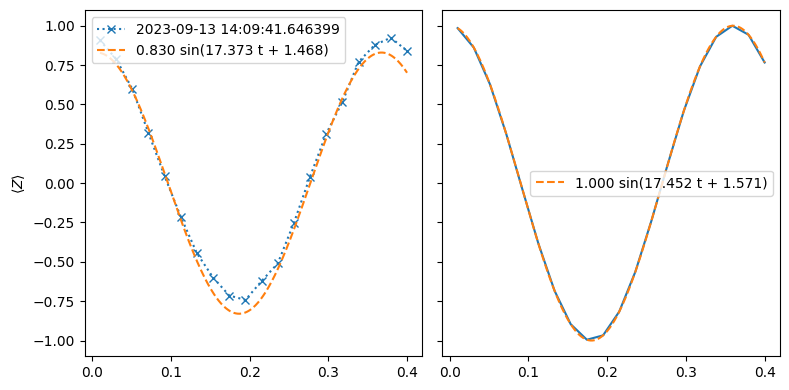

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4), sharey=True)

# device results
ax = axs[0]
dat0 = np.load("data/2023-09-14 13:36:45.315316_scan_amps_sim-False.npz", allow_pickle=True)
x_lucy, y_lucy = dat0["amps"], dat0["result"]
x_lucy_fit, y_lucy_fit, coeffs_fit_lucy = fit_sinus(x_lucy, y_lucy, [1., 15, 1.])
ax.plot(x_lucy, y_lucy, "x:", label="2023-09-13 14:09:41.646399")
ax.plot(x_lucy_fit, y_lucy_fit, "--", label=f"{coeffs_fit_lucy[0]:.3f} sin({coeffs_fit_lucy[1]:.3f} t + {coeffs_fit_lucy[2]:.3f})")


ax.set_ylabel("$\\langle Z \\rangle$")
ax.legend()

# sim
res_sim = jax.vmap(qnode_sim)(amps[:, jnp.newaxis])
x_sim_fit, y_sim_fit, coeffs_fit_sim = fit_sinus(x_lucy, res_sim, [1., 0.5, 5.])
ax = axs[1]
ax.plot(x_lucy, res_sim)
ax.plot(x_sim_fit, y_sim_fit, "--", label=f"{coeffs_fit_sim[0]:.3f} sin({coeffs_fit_sim[1]:.3f} t + {coeffs_fit_sim[2]:.3f})")
ax.legend()

plt.tight_layout()

In [16]:
E_exact_lucy = -0.83 # - coeffs_fit_lucy[0]

# VQE
Find minimum using gradients and optimization

In [19]:
def run_opt(value_and_grad, theta, n_epochs=10, lr=0.1, E_exact=0.): # , b1=0.9, b2=0.999

    optimizer = optax.sgd(learning_rate=lr)#, b1=b1, b2=b2)
    opt_state = optimizer.init(theta)

    energy = np.zeros(n_epochs)
    gradients = []
    thetas = [theta]

    t0 = datetime.now()

    for n in range(n_epochs):
        val, grad_circuit = value_and_grad(theta)
        # theta = theta - lr * grad_circuit
        updates, opt_state = optimizer.update(grad_circuit, opt_state)
        theta = optax.apply_updates(theta, updates)

        energy[n] = val
        gradients.append(
            grad_circuit
        )
        thetas.append(
            theta
        )
        print(f"{n+1} / {n_epochs}; energy discrepancy: {val-E_exact} moving to {theta} = {theta + lr*grad_circuit} - {lr} * {grad_circuit}")
    t1 = datetime.now()
    print(f"Final energy discrepancy: {val-E_exact} after {t1 - t0}")
    
    return thetas[:-1], energy, gradients

In [20]:
value_and_grad_jax = jax.value_and_grad(qnode_sim)

In [21]:
lr, n_epochs = 0.001, 50
theta0 = jnp.array([0.1])
thetaf, energy, gradients = run_opt(value_and_grad_jax, theta0, lr=lr, n_epochs=n_epochs, E_exact=-1)

name = f"data/{datetime.now()}_1-qubit-vqe-Z-sim_lr-{lr}_n-epochs-{n_epochs}"
print(name)
np.savez(name, thetaf=thetaf, energy=energy, gradients=gradients)

1 / 50; energy discrepancy: 0.8264982104301453 moving to [0.11718637] = [0.1] - 0.001 * [-17.186367]
2 / 50; energy discrepancy: 0.543254554271698 moving to [0.13270977] = [0.11718637] - 0.001 * [-15.5233965]
3 / 50; energy discrepancy: 0.32195091247558594 moving to [0.14553675] = [0.13270977] - 0.001 * [-12.826975]
4 / 50; energy discrepancy: 0.1756453514099121 moving to [0.1554153] = [0.14553675] - 0.001 * [-9.87855]
5 / 50; energy discrepancy: 0.0907488465309143 moving to [0.16267885] = [0.1554153] - 0.001 * [-7.263551]
6 / 50; energy discrepancy: 0.04556417465209961 moving to [0.1678778] = [0.16267885] - 0.001 * [-5.198938]
7 / 50; energy discrepancy: 0.022359013557434082 moving to [0.17154707] = [0.1678778] - 0.001 * [-3.6692832]
8 / 50; energy discrepancy: 0.010955214500427246 moving to [0.17412035] = [0.17154707] - 0.001 * [-2.5732799]
9 / 50; energy discrepancy: 0.005350172519683838 moving to [0.1759125] = [0.17412035] - 0.001 * [-1.7921457]
10 / 50; energy discrepancy: 0.00256

Minimal energy discrepancy 1.3709068298339844e-06 after 35 epochs with amplitude 0.1800173968076706


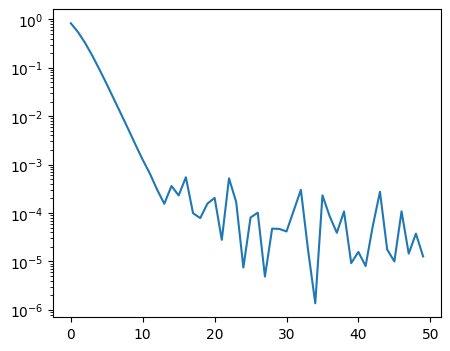

In [23]:
fig, ax = plt.subplots(ncols=1, figsize=(5,4))

datsim = np.load("data/2023-09-14 13:43:07.723052_1-qubit-vqe-Z-sim_lr-0.001_n-epochs-50.npz", allow_pickle=True)
energy = datsim["energy"]
thetas = datsim["thetaf"]
min_ = np.argmin(energy)
thetaf = thetas[min_]
print(f"Minimal energy discrepancy {energy[min_]-E_exact} after {min_+1} epochs with amplitude {thetaf[0]}")

ax.plot(energy - E_exact)
ax.set_yscale("log")

In [25]:
value_and_grad_lucy = jax.value_and_grad(qnode_lucy)

In [ ]:
# # dat = np.load("data/2023-09-13 14:38:52.610499_1-qubit-vqe-Z-lucy_lr-0.1_n-epochs-50.npz", allow_pickle=True)
# lr, n_epochs = 0.1, 30
# # theta0 = dat["thetaf"][-1]
# theta0 = jnp.array([0.1])
# thetaf, energy, gradients = run_opt(value_and_grad_lucy, theta0, lr=lr, n_epochs=n_epochs, E_exact=E_exact_lucy)

# name = f"data/{datetime.now()}_1-qubit-vqe-Z-lucy_lr-{lr}_n-epochs-130"
# print(name)
# np.savez(name, thetaf=np.concatenate([dat["thetaf"], thetaf[1:]]), energy=np.concatenate([dat["energy"], energy]), gradients=np.concatenate([dat["gradients"], gradients]))

In [13]:
14*3*0.65

27.3

In [29]:
# dat = np.load("data/2023-09-13 14:38:52.610499_1-qubit-vqe-Z-lucy_lr-0.1_n-epochs-50.npz", allow_pickle=True)
lr, n_epochs = 0.01, 30
# theta0 = dat["thetaf"][-1]
theta0 = jnp.array([0.1])
name = f"data/{datetime.now()}_1-qubit-vqe-Z-lucy_lr-{lr}_n-epochs-50"
print(name)
thetaf, energy, gradients = run_opt(value_and_grad_lucy, theta0, lr=lr, n_epochs=n_epochs, E_exact=E_exact_lucy)


np.savez(name, thetaf=thetaf, energy=energy, gradients=gradients)

data/2023-09-14 14:01:55.219834_1-qubit-vqe-Z-lucy_lr-0.01_n-epochs-50
1 / 30; energy discrepancy: 0.8259999752044678 moving to [0.14596963] = [0.10000001] - 0.01 * [-4.5969625]
2 / 30; energy discrepancy: 0.24799996614456177 moving to [0.17488107] = [0.14596963] - 0.01 * [-2.8911436]
3 / 30; energy discrepancy: 0.11599999666213989 moving to [0.18500192] = [0.17488107] - 0.01 * [-1.0120847]
4 / 30; energy discrepancy: 0.07999998331069946 moving to [0.17973648] = [0.18500192] - 0.01 * [0.5265447]
5 / 30; energy discrepancy: 0.11399996280670166 moving to [0.19063011] = [0.17973648] - 0.01 * [-1.0893621]
6 / 30; energy discrepancy: 0.11399996280670166 moving to [0.15747555] = [0.19063011] - 0.01 * [3.3154564]
7 / 30; energy discrepancy: 0.15200001001358032 moving to [0.17761473] = [0.15747555] - 0.01 * [-2.0139186]
8 / 30; energy discrepancy: 0.09799998998641968 moving to [0.18874334] = [0.17761473] - 0.01 * [-1.1128608]
9 / 30; energy discrepancy: 0.08399999141693115 moving to [0.1471491

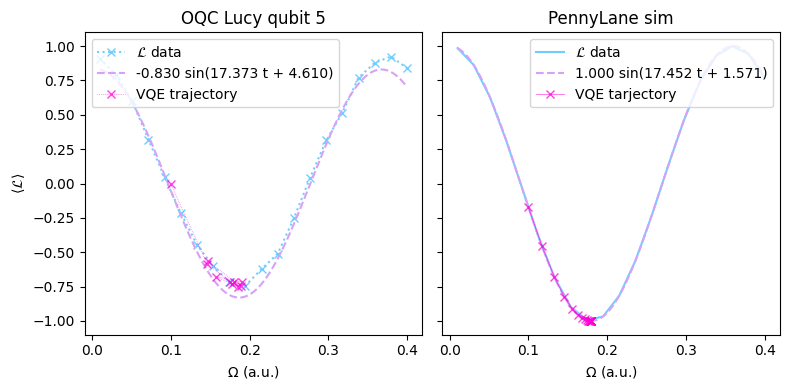

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4), sharey=True)
color = ['#70CEFF', '#D7A2F6', '#ff00d9bc', '#FF87EB', '#FFE096', '#FDC9DE', '#E1EBA8', '#C6FDD9']

# device results
ax = axs[0]
ax.set_title(f"OQC Lucy qubit {wire}")

dat0 = np.load("data/2023-09-14 13:36:45.315316_scan_amps_sim-False.npz", allow_pickle=True)
x_lucy, y_lucy = dat0["amps"], dat0["result"]
x_lucy_fit, y_lucy_fit, coeffs_fit_lucy = fit_sinus(x_lucy, y_lucy, [1., 15., 5.])
ax.plot(x_lucy, y_lucy, "x:", label="$\\mathcal{{L}}$ data", color=color[0])
ax.plot(x_lucy_fit, y_lucy_fit, "--", label=f"{coeffs_fit_lucy[0]:.3f} sin({coeffs_fit_lucy[1]:.3f} t + {coeffs_fit_lucy[2]:.3f})", color=color[1])


ax.set_ylabel("$\\langle \\mathcal{{L}} \\rangle$")

dat = np.load("data/2023-09-14 14:01:55.219834_1-qubit-vqe-Z-lucy_lr-0.01_n-epochs-50.npz", allow_pickle=True)
energy = dat["energy"] ; thetas = dat["thetaf"][:, 0]
ax.plot(thetas[:10], energy[:10], "x:", linewidth=0.5, label="VQE trajectory", color=color[2])

ax.legend()
ax.set_xlabel("$\\Omega$ (a.u.)")

# sim
amps = jnp.linspace(0.01, 0.4, 20)
res_sim = jax.vmap(qnode_sim)(amps[:, jnp.newaxis])
x_sim_fit, y_sim_fit, coeffs_fit_sim = fit_sinus(x_lucy, res_sim, [1., 0.5, 5.])

ax = axs[1]
ax.set_title(f"PennyLane sim")
ax.plot(x_lucy, res_sim, label="$\\mathcal{{L}}$ data", color=color[0])
ax.plot(x_sim_fit, y_sim_fit, "--", label=f"{coeffs_fit_sim[0]:.3f} sin({coeffs_fit_sim[1]:.3f} t + {coeffs_fit_sim[2]:.3f})", color=color[1])

datsim = np.load("data/2023-09-14 13:43:07.723052_1-qubit-vqe-Z-sim_lr-0.001_n-epochs-50.npz", allow_pickle=True)
energy = datsim["energy"] ; thetas = datsim["thetaf"][:, 0]
ax.plot(thetas, energy, "x-", linewidth=0.5, label="VQE tarjectory", color=color[2])

ax.legend(loc=1)
ax.set_xlabel("$\\Omega$ (a.u.)")

plt.tight_layout()
plt.savefig("VQE_OQC.png", dpi=500)

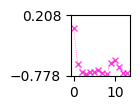

In [10]:
fig, ax = plt.subplots(figsize=(1.5,1.2))
dat = np.load("data/2023-09-14 14:01:55.219834_1-qubit-vqe-Z-lucy_lr-0.01_n-epochs-50.npz", allow_pickle=True)
energy = dat["energy"] ; thetas = dat["thetaf"][:, 0]
ax.plot(energy[:14], "x:", markersize=4, linewidth=0.5, label="VQE", color=color[2])
ax.set_yticks([np.min(energy), np.max(energy)])
plt.tight_layout()
plt.savefig('VQE_OQC_lucy_inset.png', transparent=True, dpi=400)

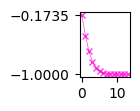

In [11]:
fig, ax = plt.subplots(figsize=(1.5,1.2))
dat = np.load("data/2023-09-14 13:43:07.723052_1-qubit-vqe-Z-sim_lr-0.001_n-epochs-50.npz", allow_pickle=True)
energy = dat["energy"] ; thetas = dat["thetaf"][:, 0]
ax.plot(energy[:14], "x-", markersize=4, linewidth=0.5, label="VQE", color=color[2])
ax.set_yticks([np.min(energy), np.max(energy)])
plt.tight_layout()
plt.savefig('VQE_OQC_sim_inset.png', transparent=True, dpi=400)